<a href="https://colab.research.google.com/github/Shivam123Tripathi/INFOSYS-_INTERNSHIP-OIL_SPILL_DETECTION-/blob/shivam-tripathi-branch/Copy_of_Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Images Path: /content/drive/MyDrive/Oil Spill dataset/dataset/train/images
Training Masks Path: /content/drive/MyDrive/Oil Spill dataset/dataset/train/masks
 Folders found!
Number of Images: 811
Number of Masks: 811
Using Image: /content/drive/MyDrive/Oil Spill dataset/dataset/train/images/Oil (1015).jpg
Using Mask: /content/drive/MyDrive/Oil Spill dataset/dataset/train/masks/Oil (1015).png


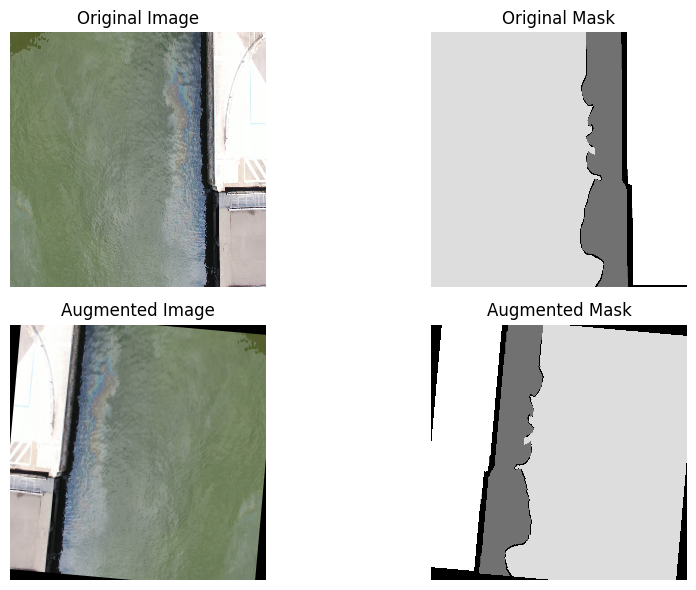

In [22]:
# STEP 1: Mounted my colab to  Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os, cv2, glob
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A

# STEP 2: Setting  base dataset path
BASE_PATH = "/content/drive/MyDrive/Oil Spill dataset/dataset"

TRAIN_IMG_DIR = os.path.join(BASE_PATH, "train/images")
TRAIN_MASK_DIR = os.path.join(BASE_PATH, "train/masks")

print("Training Images Path:", TRAIN_IMG_DIR)
print("Training Masks Path:", TRAIN_MASK_DIR)

# STEP 3: Here Checking  if folders exist or not that we wantt to train
if not os.path.exists(TRAIN_IMG_DIR):
    raise FileNotFoundError(f" Could not find {TRAIN_IMG_DIR}. Check folder name in Drive.")
if not os.path.exists(TRAIN_MASK_DIR):
    raise FileNotFoundError(f" Could not find {TRAIN_MASK_DIR}. Check folder name in Drive.")

print(" Folders found!")
print("Number of Images:", len(os.listdir(TRAIN_IMG_DIR)))
print("Number of Masks:", len(os.listdir(TRAIN_MASK_DIR)))

# STEP 4: Preprocessing functions(preprocess image then masking etc)
IMG_SIZE = (256, 256)

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    return img

def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, IMG_SIZE)
    mask = mask / 255.0   # normalize to 0/1
    return mask

# STEP 5: Picking a sample image and its mask (handles .png/.jpg automatically)
sample_image_name = os.listdir(TRAIN_IMG_DIR)[0]   # first image
img_path = os.path.join(TRAIN_IMG_DIR, sample_image_name)

# find matching mask
mask_candidates = glob.glob(os.path.join(TRAIN_MASK_DIR, sample_image_name.split('.')[0] + ".*"))
if not mask_candidates:
    raise FileNotFoundError(f" No mask found for {sample_image_name}")
mask_path = mask_candidates[0]

print("Using Image:", img_path)
print("Using Mask:", mask_path)

# Load them
img = preprocess_image(img_path)
mask = preprocess_mask(mask_path)

# STEP 6: Augmentation (flip + rotate)  image..
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=30, p=0.5)
])

augmented = augment(image=img, mask=mask)
aug_img = augmented['image']
aug_mask = augmented['mask']

# STEP 7: Visualization (Original vs Augmented)
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(mask, cmap='gray')
plt.title("Original Mask")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(aug_img)
plt.title("Augmented Image")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(aug_mask, cmap='gray')
plt.title("Augmented Mask")
plt.axis('off')

plt.tight_layout()
plt.show()




#week 3-4
import tensorflow as tf
from tensorflow.keras import layers, models

# Simple U-Net like model
def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    b = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(64, (3,3), activation='relu', padding='same')(b)

    # Decoder
    u1 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(b)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c3)

    u2 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c4)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model





In [1]:

import time, os, glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K

# Dice and IoU definitions (numpy for evaluation, Keras for loss) ---
def dice_coef_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    inter = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

# Keras dice loss
def dice_loss_keras(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Combined loss: BinaryCrossentropy + Dicee
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dl = dice_loss_keras(y_true, y_pred)
    return bce + dl

# IoU metric for training display (keras)
def iou_keras(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    inter = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

#  Model builder
def build_unet(input_shape=(256,256,3)):
    inputs = tf.keras.layers.Input(shape=input_shape)
    # Encoder
    c1 = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    b = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(p2)
    b = tf.keras.layers.Conv2D(64,3,activation='relu',padding='same')(b)

    u1 = tf.keras.layers.Conv2DTranspose(32,2,strides=2,padding='same')(b)
    u1 = tf.keras.layers.concatenate([u1, c2])
    c3 = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(u1)
    c3 = tf.keras.layers.Conv2D(32,3,activation='relu',padding='same')(c3)

    u2 = tf.keras.layers.Conv2DTranspose(16,2,strides=2,padding='same')(c3)
    u2 = tf.keras.layers.concatenate([u2, c1])
    c4 = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(u2)
    c4 = tf.keras.layers.Conv2D(16,3,activation='relu',padding='same')(c4)

    outputs = tf.keras.layers.Conv2D(1,1,activation='sigmoid')(c4)
    model = tf.keras.models.Model(inputs, outputs)
    return model


In [9]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
mask_name = fn.split('.')[0] + ".png"


In [12]:
mask_name = fn.split('.')[0] + ".jpg"  # or ".tif" if masks are tif


In [18]:
import os, numpy as np, tensorflow as tf
from tqdm import tqdm  # shows a progress bar

IMG_SIZE = (256, 256)

def preprocess_image_simple(p):
    img = tf.keras.preprocessing.image.load_img(p, target_size=IMG_SIZE)
    arr = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    return arr

def preprocess_mask_simple(p):
    m = tf.keras.preprocessing.image.load_img(p, target_size=IMG_SIZE, color_mode='grayscale')
    ma = tf.keras.preprocessing.image.img_to_array(m) / 255.0
    ma = (ma > 0.5).astype(np.float32)
    return ma

#   dataset paths
TRAIN_IMG_DIR = "/content/drive/MyDrive/Oil Spill dataset/dataset/train/images"
TRAIN_MASK_DIR = "/content/drive/MyDrive/Oil Spill dataset/dataset/train/masks"

# Check folders
if not os.path.exists(TRAIN_IMG_DIR):
    raise FileNotFoundError(f"❌ Could not find {TRAIN_IMG_DIR}")
if not os.path.exists(TRAIN_MASK_DIR):
    raise FileNotFoundError(f"❌ Could not find {TRAIN_MASK_DIR}")

img_files = sorted([f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith(('.png','.jpg','.tif','.jpeg'))])

X_list, y_list = [], []

#  Load only first 50 images for testing
for fn in tqdm(img_files[:50], desc="Loading images"):
    img_path = os.path.join(TRAIN_IMG_DIR, fn)
    mask_name = fn.split('.')[0] + ".png"  # adjust if mask is .jpg
    mask_path = os.path.join(TRAIN_MASK_DIR, mask_name)
    if os.path.exists(mask_path):
        X_list.append(preprocess_image_simple(img_path))
        y_list.append(preprocess_mask_simple(mask_path))

X = np.array(X_list, dtype=np.float32)
y = np.array(y_list, dtype=np.float32).reshape(-1, 256, 256, 1)

print(" Dataset Loaded")
print("X shape:", X.shape, "y shape:", y.shape)


Loading images: 100%|██████████| 50/50 [00:02<00:00, 19.13it/s]

 Dataset Loaded
X shape: (50, 256, 256, 3) y shape: (50, 256, 256, 1)


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)


Train: (40, 256, 256, 3) (40, 256, 256, 1)
Val: (10, 256, 256, 3) (10, 256, 256, 1)


In [20]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ---Here i've  Build a Simple U-Net ---
def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    # Bottleneck
    b = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    b = layers.Conv2D(64, (3,3), activation='relu', padding='same')(b)

    # Decoder
    u1 = layers.Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(b)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c3)

    u2 = layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c4)

    return Model(inputs, outputs)

# Build and compile model
model = build_unet(input_shape=X_train.shape[1:])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

# Train for 5 epochs  ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=8
)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │      8,224 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │     18,464 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_6[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 256, 256,  │      2,064 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │      4,624 │ concatenate_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 256, 256,  │      2,320 │ conv2d_8[0][0]  

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.7977 - loss: 0.6480 - val_accuracy: 0.7857 - val_loss: 0.5152
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.8427 - loss: 0.4626 - val_accuracy: 0.7857 - val_loss: 0.5163
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8224 - loss: 0.4756 - val_accuracy: 0.7857 - val_loss: 0.5067
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.8264 - loss: 0.4659 - val_accuracy: 0.7857 - val_loss: 0.5070
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.8233 - loss: 0.4605 - val_accuracy: 0.7857 - val_loss: 0.5103


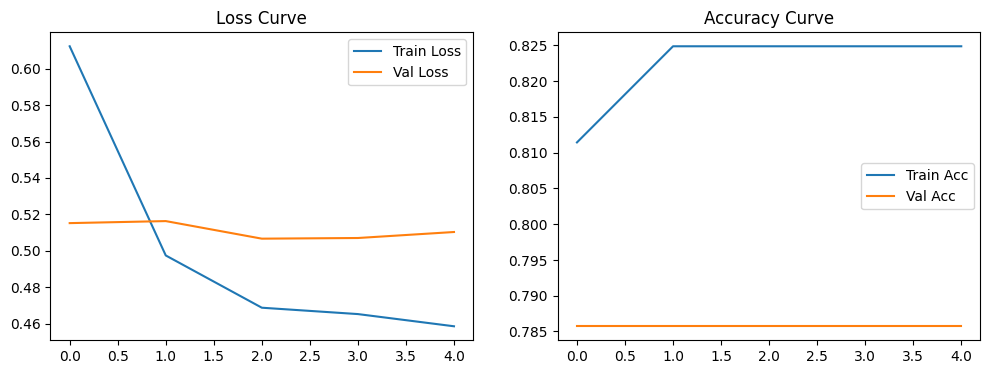

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve")
plt.legend()

plt.show()
